# Inference: Metropolis-Adjusted Langevin Algorithm (MALA)

This example shows you how to perform Bayesian inference on a Normal distribution and a time-series problem, using MALA for MCMC.

First, we create a simple normal distribution

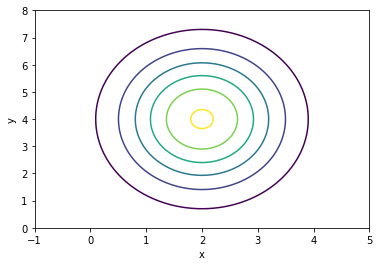

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we set up and run a sampling routine using MALA MCMC

In [2]:
# Choose starting points for 3 mcmc chains
xs = [
    [2, 1],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.MALAMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# # Update step sizes used by individual samplers (which is then scaled by sigma0)
for sampler in mcmc.samplers():
    sampler.set_epsilon([1.5, 1.5])

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Metropolis-Adjusted Langevin Algorithm (MALA)
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0.5        0:00.0
2     9      0         0.667     0.667      0:00.0
3     12     0.25      0.5       0.75       0:00.0
100   303    0.723     0.673     0.832      0:00.3
200   603    0.751     0.741     0.796      0:00.5
300   903    0.767     0.751     0.797      0:00.8
400   1203   0.736     0.743     0.771      0:01.1
500   1503   0.750499  0.748503  0.752495   0:01.4
600   1803   0.757     0.76      0.747      0:01.6
700   2103   0.753     0.755     0.743224   0:01.9
800   2403   0.75      0.757     0.735      0:02.2
900   2703   0.75      0.757     0.73       0:02.4
1000  3003   0.751     0.756     0.733      0:02.7
1100  3303   0.751     0.752     0.736      0:03.0
1200  3603   0.749     0.746045  0.729      0:03.2
1300  3903   0.743   

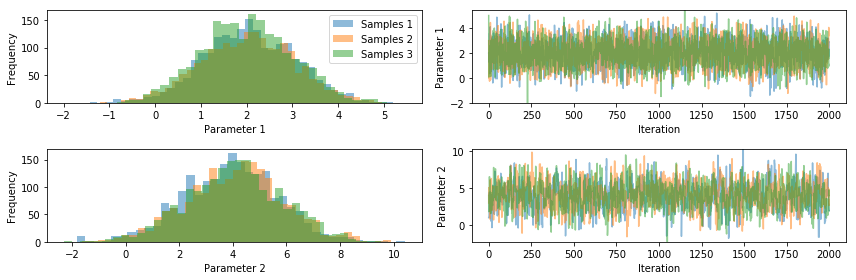

In [3]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

R-hat:
[1.0011357940509646, 1.0017031271797681]
0.0103631865061
0.00530188143198
0.00250108715373


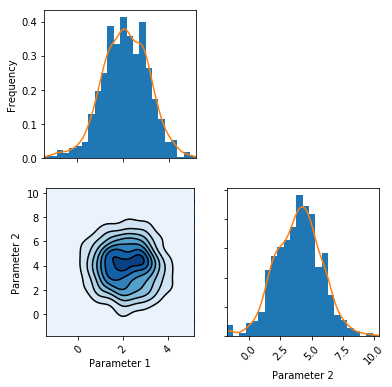

In [4]:
# Discard warm up
chains = full_chains[:, 1000:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

## MAMA MCMC on a time-series problem

We now try the same method on a time-series problem

First, we try it in 1d, using a wrapper around the LogisticModel to make it one-dimensional.

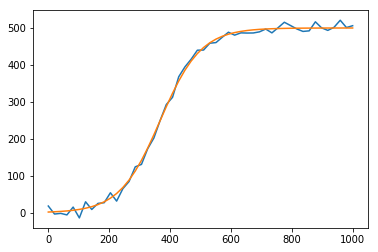

In [5]:
import pints.toy as toy

# Create a wrapper around the logistic model, turning it into a 1d model
class Model(pints.ForwardModel):
    def __init__(self):
        self.model = toy.LogisticModel()
    def simulate(self, x, times):
        return self.model.simulate([x[0], 500], times)
    def simulateS1(self, x, times):
        values, gradient = self.model.simulateS1([x[0], 500], times)
        gradient = gradient[:, 0]
        return values, gradient
    def n_parameters(self):
        return 1

# Load a forward model
model = Model()
    
# Create some toy data
real_parameters = np.array([0.015])
times = np.linspace(0, 1000, 50)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.figure()
plt.plot(times, values)
plt.plot(times, org_values)
plt.show()

### Now running MALA MCMC

In [6]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01],
    [0.02]
)

log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_likelihood, len(xs), xs, method=pints.MALAMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Metropolis-Adjusted Langevin Algorithm (MALA)
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0.5       0.5        0:00.0
2     9      0.667     0.667     0.667      0:00.0
3     12     0.75      0.75      0.75       0:00.0
100   303    0.990099  0.990099  0.990099   0:00.3
200   603    0.995     0.995     0.99       0:00.6
300   903    0.993     0.993     0.99       0:00.9
400   1203   0.995     0.993     0.993      0:01.2
500   1503   0.992016  0.988024  0.99002    0:01.5
600   1803   0.992     0.99      0.99       0:01.8
700   2103   0.993     0.991     0.991      0:02.1
800   2403   0.99      0.993     0.993      0:02.4
900   2703   0.988     0.993     0.992      0:02.6
1000  3003   0.988012  0.994006  0.993007   0:02.9
1100  3303   0.988     0.995     0.993      0:03.2
1200  3603   0.989     0.994     0.993      0:03.5
1300  3903   0.99    

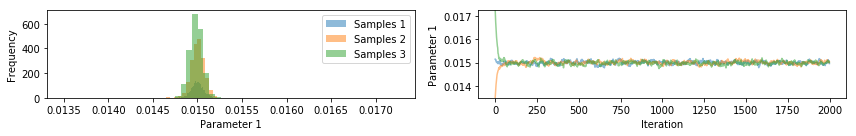

In [7]:
# Show trace and histogram
pints.plot.trace(chains)
plt.show()

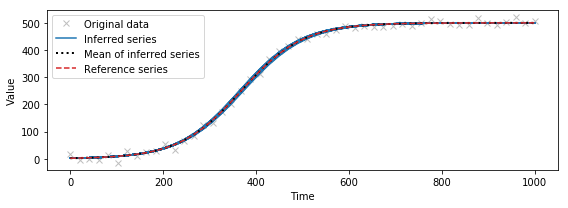

In [8]:
# Show predicted time series for the first chain
pints.plot.series(chains[0, 200:], problem, real_parameters)
plt.show()

## 2d Time series

Finally, we try MALA MCMC on a 2d logistic model problem.

In [9]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.MALAMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Metropolis-Adjusted Langevin Algorithm (MALA)
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0.5       0.5        0:00.0
2     9      0.333     0.667     0.667      0:00.0
3     12     0.5       0.75      0.75       0:00.0
100   303    0.970297  0.970297  0.980198   0:00.3
200   603    0.975     0.98      0.99       0:00.6
300   903    0.98      0.983     0.986711   0:00.9
400   1203   0.975     0.985     0.985      0:01.2
500   1503   0.976     0.984     0.986      0:01.5
600   1803   0.975     0.987     0.985025   0:01.8
700   2103   0.977     0.989     0.984      0:02.1
800   2403   0.974     0.99      0.985      0:02.4
900   2703   0.977     0.99      0.984      0:02.7
1000  3003   0.979021  0.991009  0.983017   0:03.0
1100  3303   0.98      0.992     0.981      0:03.3
1200  3603   0.981     0.992     0.981      0:03.6
1300  3903   0.982   

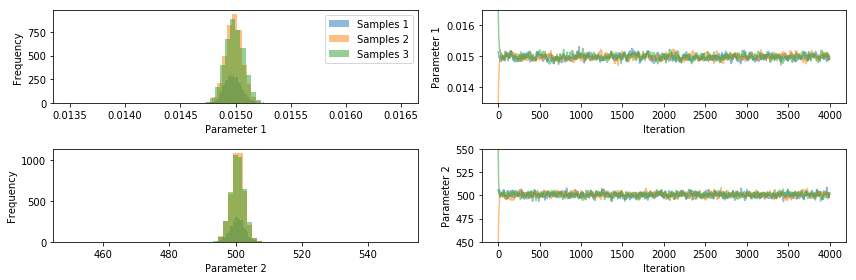

In [10]:
# Show traces and histograms
pints.plot.trace(chains)
plt.show()

Chains have converged!

In [11]:
# Discard warm up
chains = chains[:, 1000:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

R-hat:
[1.0035953753279669, 0.99995026418452926]
